## Analyze A/B Test Results

### Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Read in the `ab_data.csv` data and store it in `df`.

a. Read in the dataset and take a look at the top few rows:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset:

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset:

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted:

In [5]:
df.query('converted == 1').shape[0]/df['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match:

In [6]:
df.query('(group == "treatment" and landing_page == "old_page") or (group == "control" and landing_page == "new_page")').shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 7.9+ MB


There are not any missing values in the dataset. 

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. To fix this, we will remove all rows where the group does not match with the page and store the new dataframe in **df2**.

In [8]:
# Remove rows where treatment is not aligned with new_page or control is not aligned with old_page
# Store the result in the new dataframe
mask = ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'control') & (df['landing_page'] == 'new_page'))
df2 = df[~mask]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Examine the new dataframe **df2**:

a. The number of unique **user_id**s in **df2**:

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**:

In [11]:
df2[df2.duplicated(subset=['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

The repeated user_id is 773192.

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(subset=['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


All information except for timestamp are the same for both rows.

d. Remove **one** of the rows with a duplicate **user_id**, but keep the dataframe as **df2**:

In [13]:
# Check the size of the dataframe before removing
df2.shape

(290585, 5)

In [14]:
# Remove duplicate
df2 = df2.drop_duplicates(subset=['user_id', 'group', 'landing_page', 'converted'])

In [15]:
# Check the size of the dataframe after removing
df2.shape

(290584, 5)

`4.` Probabilities from the dataframe **df2**:

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2.query('converted == 1').shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Conclusions based on the results from parts (a) through (d) above:

The probability of an individual converting regardless of the page they receive (11.96%) is close to the probabilities of an individual in a control group (12.04%) and of an individual in a treatment group (11.88%). The probability that an individual received the new page is 50%. Moreover, the observed probability that an individual in a control group converted is higher than the probability that an individual in a treatment group converted.  <br><br>
Considering only these observations without any further testing, there is not sufficient evidence to say that the new treatment page leads to more conversions. Comparison of the probabilities suggests the opposite - the new treatment page does not lead to more conversions. However, it cannot be said for sure without testing and determining statistical significance. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do we run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null hypothesis:** The conversion rate for the old page is greater than or equal to the conversion rate for the new page. In other words, the old page is better or as good as the new page in terms of conversions.  

$H_{0}$: $p_{new}$ $\leq$ $p_{old}$  

or

$H_{0}$: $p_{new}$ - $p_{old}$ $\leq$ 0  <br><br>

**Alternative hypothesis:** The conversion rate for the new page is greater than the conversion rate for the old page. That is, the new page is better than the old page in terms of conversions.  

$H_{1}$: $p_{new}$ > $p_{old}$  

or

$H_{1}$: $p_{new}$ - $p_{old}$ > 0  

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>
Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
df2['converted'].mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null?

In [21]:
df2['converted'].mean()

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
df2.query('group == "treatment"').shape[0]

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
df2.query('group == "control"').shape[0]

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], size = df2.query('group == "treatment"').shape[0], p=[1-df2['converted'].mean(), df2['converted'].mean()])

In [25]:
# Check if the size is as expected
new_page_converted.shape

(145310,)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0, 1], size = df2.query('group == "control"').shape[0], p=[1-df2['converted'].mean(), df2['converted'].mean()])

In [27]:
# Check if the size is as expected
old_page_converted.shape

(145274,)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
new_page_converted.mean() - old_page_converted.mean()

-0.00025696515406106735

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
size_new = df2.query('group == "treatment"').shape[0]
size_old = df2.query('group == "control"').shape[0]

p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = size_new, p=[1-df2['converted'].mean(), df2['converted'].mean()])
    old_page_converted = np.random.choice([0, 1], size = size_old, p=[1-df2['converted'].mean(), df2['converted'].mean()])
    new_page_mean = new_page_converted.mean()
    old_page_mean = old_page_converted.mean()
    p_diff = new_page_mean - old_page_mean
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**:

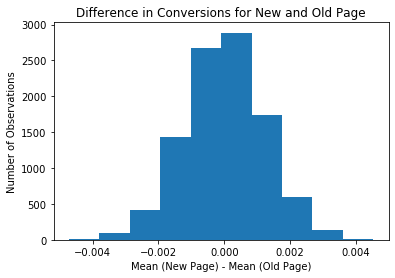

In [30]:
# Histogram of the differences
plt.hist(p_diffs)
plt.title('Difference in Conversions for New and Old Page')
plt.xlabel('Mean (New Page) - Mean (Old Page)')
plt.ylabel('Number of Observations');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
# Actual difference observed in the data
p_diff_obs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()

# Calculation of the p-value
(p_diffs > p_diff_obs).mean()

0.9075

In [32]:
# Print the actual difference observed in the data
p_diff_obs

-0.0015782389853555567

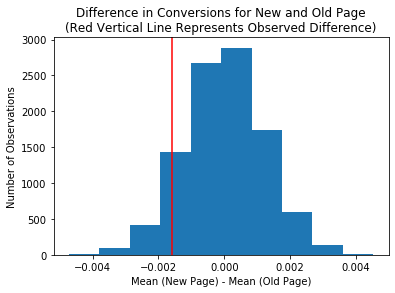

In [33]:
# Histogram with the observed difference
plt.hist(p_diffs)
plt.title('Difference in Conversions for New and Old Page\n(Red Vertical Line Represents Observed Difference)')
plt.xlabel('Mean (New Page) - Mean (Old Page)')
plt.ylabel('Number of Observations')
plt.axvline(x=p_diff_obs, color='r');

k. Interpretation and conclusions:

The calculated value is a p-value, which is the probability of observing the observed statistic or a more extreme value assuming that the null hypothesis is correct.  <br><br>
The p-value is compared to the threshold for type I errors, $\alpha$, which is in our case 0.05 (5%). If p-value > $\alpha$, we fail to reject the null hypothesis. If p-value $\leq$ $\alpha$, we reject the null hypothesis. In our case, p-value > 0.05. Therefore we can conclude that we fail to reject the null hypothesis. The new landing page is not better than the old landing page at a significance level of 0.05. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

In [35]:
# Print the number of conversions for each page and the number of individuals who received each page
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [36]:
from statsmodels.stats.proportion import proportions_ztest

counts = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])

stat, pval = proportions_ztest(counts, nobs, alternative='smaller')    # in our case 'smaller' means that p_old < p_new
stat, pval

(1.3109241984234394, 0.9050583127590245)

n. Interpretation and conclusions:

Z-score gives the probability of a normal random variable not being more than z standard deviations above its mean. If the calculated z-score is larger than a critical value, the null hypothesis can be rejected. The critical value of z-score for $\alpha$ = 0.05 is 1.645. The calculated z-score is smaller than this value, and we fail to reject the null hypothesis. The p-value from z-test is close to the p-value calculated previously. Based on the z-score and p-value from the z-test, it can be concluded that we fail to reject the null hypothesis. The new page is not better in terms of conversions comparing to the old page.<br><br>
Findings based on previous simulations and z-test are in agreement - we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Since we want to predict categorical variable (converted: yes/no), logistic regression should be performed. 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
# Add intercept
df2['intercept'] = 1

# Add dummy variable column for received page
page_dummy = pd.get_dummies(df2['landing_page'])
df2 = df2.join(page_dummy)
df2 = df2.drop(['old_page'], axis=1)
df2 = df2.rename(columns={'new_page':'ab_page'})

In [38]:
# Check the resulting dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [39]:
# Instantiate and fit the logistic regression model
log_reg = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_reg.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
# Summary of the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 14 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        19:47:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

The p-value associated with ab_page is 0.190. Here, the p-value determines whether the dependent variable is statistically significant for predictions. Since it is larger than 0.05, ab_page is not significant when predicting the conversion. <br><br>
The p-value from regression model differs from the p-value from Part II, because it's a p-value connected with a different pair of null and alternative hypotheses. In Part II, the null and alternative hypotheses are built around the comparison between the conversion rates in the control and treatment groups. In Part III, the null and alternative hypotheses are based on the comparison of the population slope ${\beta}$ in the regression model with 0. <br><br>
**Null hypothesis:** The population slope is equal to zero.  

$H_{0}$: ${\beta}$ = 0  <br><br>
**Alternative hypothesis:** The population slope is different from zero.  

$H_{1}$: ${\beta}$ $\neq$ 0  <br><br>

When we are studying whether the predictions are influenced by a particular factor (in this case: the effect of the new landing page), we want to prove the alternative hypothesis. The null hypothesis says that there is no such effect. If the p-value is low, we can reject the null hypothesis and use the computed parameter in our prediction - we say that the factor is statistically significant in the prediction. However, the p-value is higher than the chosen ${\alpha}$ value in our case, so we should not reject the null hypothesis saying that the slope is equal to zero. In other words, the studied variable does not affect the conversion. 

To sum it up, we calculated two different p-values, because we were testing different null and alternative hypotheses, although we studied exactly the same problem - effect of an individual being exposed to a new/old landing page on his/her conversion. 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Examples of factors that might influence the prediction of conversion rates could be following: age, education, employment, financial situation, how much is an individual happy with the current state, how long is an individual with the current service, whether an individual likes changes or not at all, or any background information. When it comes to the web page itself, it might also depend whether an individual looks at the page in a mobile device or a computer (perhaps the perception of the page is different when it comes to different media), or whether an individual has good internet connection. Other factor to consider is also the total time of the experiment, as already mentioned above.  <br><br> 
The additional factors considered in the regression model could lead to better predictions and could shed light into relations that would otherwise remain hidden; including of them might be essential to understand how the underlying data relates to the predicted variables. Except for adding other factors, we could add also interactions among them or higher-order terms that can make predictions even better. On the other hand, the more factors, higher-order terms and interactions in the model, the more difficult interpretation would be. We can loose the chance to clearly see the influence of the factors in case the model is too complex.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns. Provide the statistical output as well as a written response to answer this question.

In [41]:
# Load countries dataset
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
# Check country values
countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [43]:
# Join datasets into new dataframe df2_new
df2_new = df2.join(countries.set_index('user_id'), on='user_id', lsuffix='_data')
df2_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [44]:
# Check the new dataframe
df2_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 8 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
intercept       290584 non-null int64
ab_page         290584 non-null uint8
country         290584 non-null object
dtypes: int64(3), object(4), uint8(1)
memory usage: 13.6+ MB


In [45]:
# View the frequency for the country
df2_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [46]:
# Create country dummies
country_dummy = pd.get_dummies(df2_new['country'])
df2_new = df2_new.join(country_dummy)
df2_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [47]:
# Instantiate and fit the logistic regression model
log_reg_country = sm.Logit(df2_new['converted'], df2_new[['intercept', 'ab_page', 'CA', 'UK']])
results = log_reg_country.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 14 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        19:47:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

The p-values associated with the countries CA and UK (US is a baseline) suggest that country is not statistically significant to predict if the user converted or not (using $\alpha$ = 0.05). 

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
# Interactions
df2_new['page_CA'] = df2_new['ab_page'] * df2_new['CA']
df2_new['page_UK'] = df2_new['ab_page'] * df2_new['UK']
df2_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,page_CA,page_UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [49]:
# Instantiate and fit the logistic regression model with interactions
log_reg_int = sm.Logit(df2_new['converted'], df2_new[['intercept', 'ab_page', 'CA', 'UK', 'page_CA', 'page_UK']])
results = log_reg_int.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 14 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        19:48:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
page_CA       -0.0469      0.054     -0.872      0.383      -0.152       0.059
page_UK        0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

Interpretation and conclusions:  

The p-values associated with the interaction terms suggest that they are not statistically significant to predict if the user converted or not (with $\alpha$ = 0.05). The factors considered in the current model cannot be used to predict if an individual converts or not.